# <center>  <font style="color:rgb(100,109,254)">Hand Keypoint Detection</font> </center>
In this notebook we'll do keypoint detection on the hands, this process is completely same as with pose detection, just the number of keypoints are different.

In [23]:
# Import Required libraries
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk
import os
%matplotlib inline

##  <font style="color:rgb(134,19,348)">Hand Keypoint Pairs</font> 


In [24]:
# Here we are defining each keypoint pair with its corresponding index.
num_of_points = 22

# This is used to draw a Skeleton.
hand_pose_pair = [[0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],
                  [0,17],[17,18],[18,19],[19,20] ]

##  <font style="color:rgb(134,19,348)">Select Model Path</font> 
select the required model path and its architecture.

In [26]:
proto_file = "Media/M4/Model/pose_deploy.prototxt"
weights = "Media/M4/Model/pose_iter_102000.caffemodel"

## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>

In [27]:
net = cv2.dnn.readNetFromCaffe(proto_file, weights)

##  <font style="color:rgb(134,19,348)">Read Image</font> 


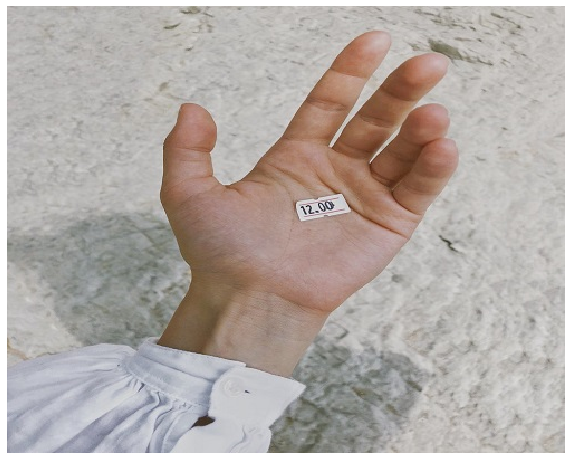

In [28]:
# Read image
image = cv2.imread("Media/M4/hand.jpeg")

# Display image
plt.figure(figsize=[10,10])
plt.imshow(image[:,:,::-1])
plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Pre-processing the image 
</font>

In [29]:
height,width = image.shape[:2]

In [30]:
# Prepare the frame to be fed to the network
inpBlob  = cv2.dnn.blobFromImage(image, 1.0 / 255, (height,width),(0, 0, 0), swapRB=False, crop=False)

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [32]:
%%time
net.setInput(inpBlob)
output = net.forward()

Wall time: 2.66 s


In [33]:
print(output.shape)

(1, 22, 63, 50)


Above you can see we got 4D matrix lets understand about them a little bit.

**output:**

- **`1:`**	ImageID for one image if you pass more than 1 image it vaies
- **`22:`**	indicates the index of a keypoint in confidence map.
- **`46:`**	 Height of the output probability map.
- **`58:`**	 Width of the output probability map.

##  <font style="color:rgb(134,19,348)">Iterate all points with probablity map </font> 
Here we will iterate over all teh prob

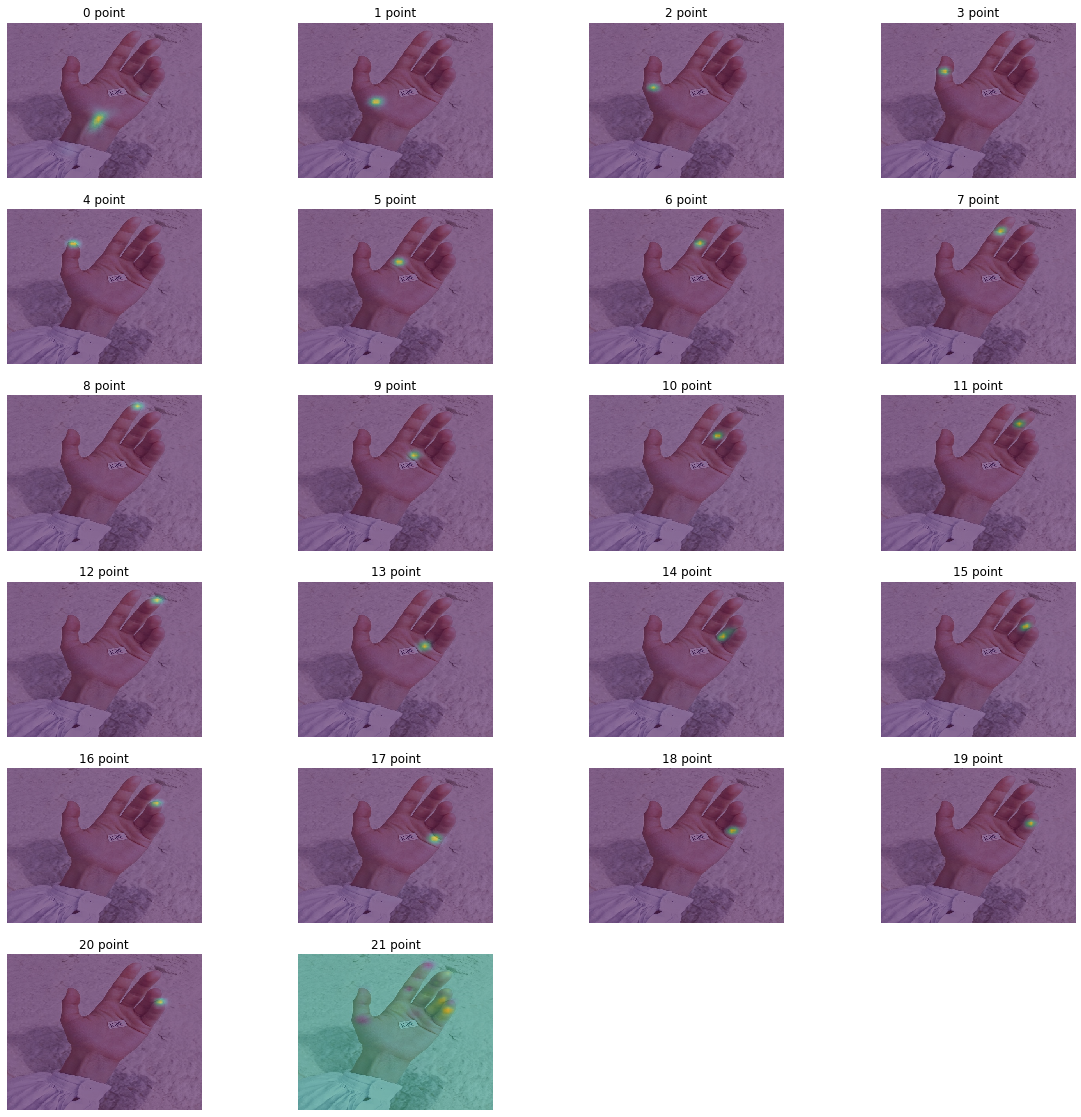

In [34]:
# Defining rows and columns
rows = 6

# Define Figure Size
plt.figure(figsize=(20,20));

# Show all points with prob map
for i in range(num_of_points):
    
    # Fetch the specific point from porbablity map 
    pro_map = output[0, i, :, :]
    
    # Here we have create the probablity same of image size 
    pro_map = cv2.resize(pro_map, (width, height))
    
    # Display it with probablity map 
    plt.subplot(rows, 4,i+1);plt.imshow(image[:,:,::-1]);plt.axis('off');

    # If you remove the probablity map you can't see the point in image
    plt.imshow(pro_map, alpha=0.5); plt.title("{} point".format(i));plt.axis('off');  

##  <font style="color:rgb(134,19,348)">Draw All individual points on original image </font> 


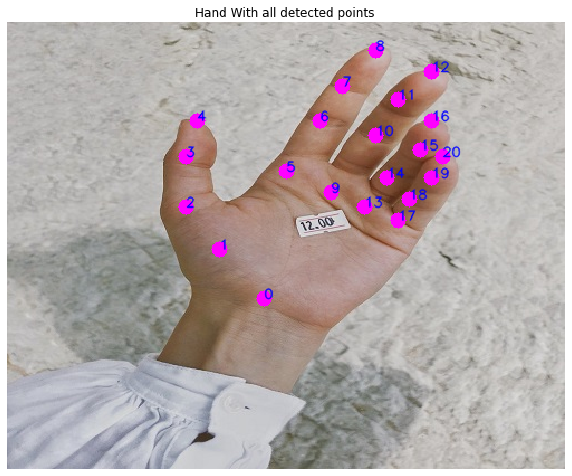

In [35]:
# Creating copy of image for showing point and skeleton of points 
img_copy = image.copy()
points = []

H = output.shape[2]
W = output.shape[3]

# Threshold value for the points to be consider 
threshold = 0.1

for i in range(22):
    
    # Fetch the specific point from porbablity map 
    pro_map = output[0, i, :, :]
    
    # Find minimum and maximum value of probablity map 
    _, probablity, _, point = cv2.minMaxLoc(pro_map)
        
    # Scaling the points for the original image
    x = (width * point[0]) / W
    y = (height * point[1]) / H
    
    # If probablity value above than given threshold than draw consider that point
    if probablity > threshold :
      
        # Draw circle and put number on each point 
        cv2.circle(img_copy, (int(x), int(y)), 7, (255, 0, 255), thickness=-2)
        cv2.putText(img_copy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1, 
                    lineType=cv2.LINE_AA)

        # Append point coordinates for futher use
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Display image   
plt.figure(figsize=[10,10])        
plt.imshow(img_copy[:,:,::-1])
plt.title("Hand With all detected points ")        
plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Draw Skeleton </font> 


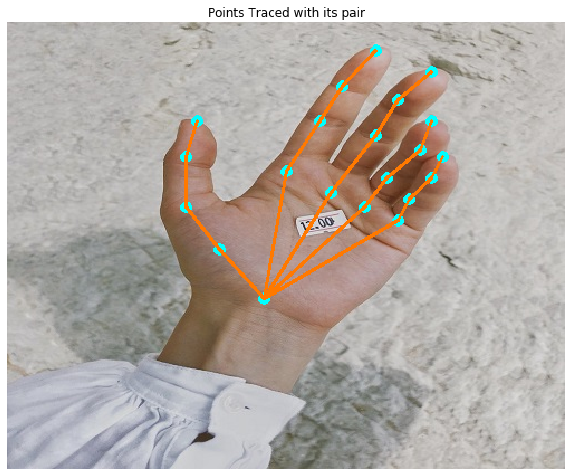

In [36]:
img_copy1 = image.copy()

for i in range(22):
    
    # Fetch the specific point from porbablity map 
    pro_map = output[0, i, :, :]
    
    # Find minimum and maximum value of probablity map 
    _, probablity, _, point = cv2.minMaxLoc(pro_map)
    
    #  Resize the points inorder to fit on image 
    x = (width * point[0]) / W
    y = (height * point[1]) / H

    if probablity > threshold : 
        cv2.circle(img_copy1, (int(x), int(y)), 5, (255, 255, 0), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Tracing point according to its sekeleton and make skeleton of hand
for pair in hand_pose_pair:
    A1 = pair[0]
    B1 = pair[1]

    if points[A1] and points[B1]:
        cv2.line(img_copy1, points[A1], points[B1], (0, 121, 255), 2)

# Display image         
plt.figure(figsize=[10,10])
plt.imshow(img_copy1[:,:,::-1])
plt.title("Points Traced with its pair")        
plt.axis('off');

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [37]:
def init_handpose(usegpu = 'None',weights_name="pose_iter_102000.caffemodel",proto_name="pose_deploy.prototxt",):
    
    # Set global variables
    global hand_pose_pair,num_of_points,net
    
    # Here we are defining the each keypoint with its corresponding index.
    num_of_points = 22
    hand_pose_pair = [ [0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],
                      [15,16],[0,17],[17,18],[18,19],[19,20] ]
    
    base_path = 'Media/M4/Model'
    
    # Defining model paths
    proto_file = os.path.join(base_path, proto_name)
    weights = os.path.join(base_path, weights_name) 
    
    # Initialize the DNN module
    net = cv2.dnn.readNetFromCaffe(proto_file, weights)
    
    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [38]:
def handpose(image=[], usercam=False,returndata=False,threshold=0.1,size=5,c_thickness=-1,l_thickness=2):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()

        # Otherwise select image from computer using tkinter        
        else:
            root = Tk()
            root.filename =  filedialog.askopenfilename(title = "Pick up the Image")
            root.withdraw()
            image = cv2.imread(root.filename)
            
    (height,width) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0 / 255, (400, 350),(0, 0, 0), swapRB=False, crop=False)
    
    # Store all points in this variable
    points = []
    
    # Forward pass
    net.setInput(blob)
    output = net.forward()
    
    H = output.shape[2]
    W = output.shape[3]
    
    for i in range(num_of_points):

        # Fetch the specific point from porbablity map 
        pro_map = output[0, i, :, :]

        # Find minimum and maximum value of probablity map 
        _, probablity, _, point = cv2.minMaxLoc(pro_map)

        #  Resize the points inorder to fit on image 
        x = (width * point[0]) / W
        y = (height * point[1]) / H

        if probablity > threshold : 
            cv2.circle(image, (int(x), int(y)), 5, (255, 255, 0), thickness=-1, lineType=cv2.FILLED)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # Tracing point according to its sekeleton and make skeleton of hand
    for pair in hand_pose_pair:
        A1 = pair[0]
        B1 = pair[1]

        if points[A1] and points[B1]:
            cv2.line(image, points[A1], points[B1], (0, 121, 255), 2)
            
    if  returndata:
        return image
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off");          

**Initialize the Pose Estimator**

In [39]:
init_handpose()

**Calling hand pose with default arguments.**

Wall time: 1.95 s


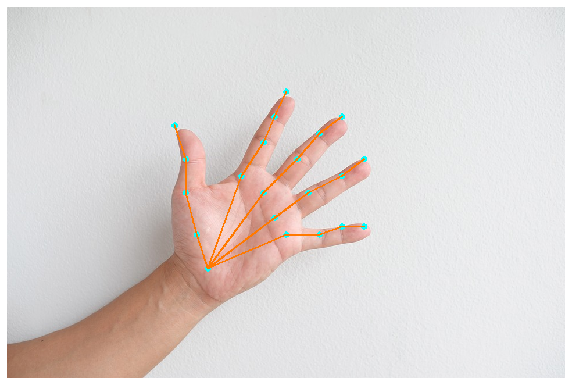

In [40]:
%%time
image = cv2.imread("Media/M4/hand1.jpg")
handpose(image)

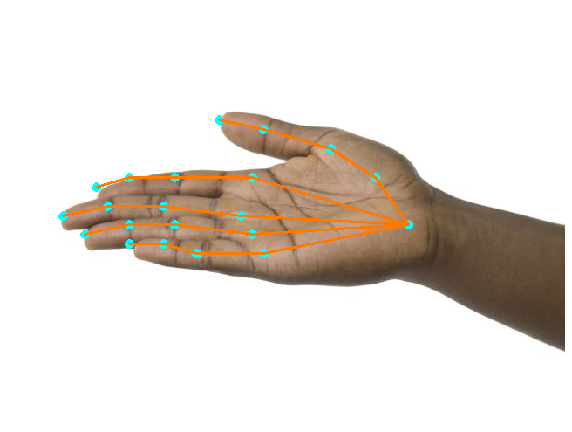

In [41]:
image = cv2.imread("Media/M4/hand12.jpg")
handpose(image)

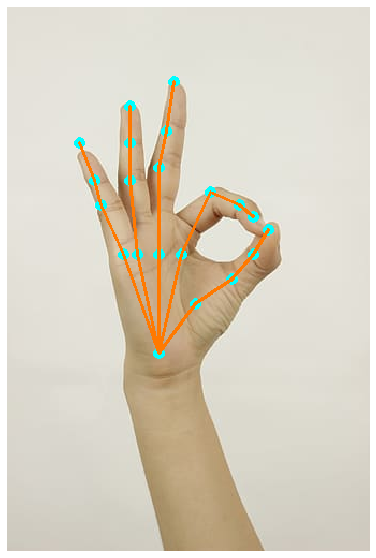

In [42]:
image = cv2.imread("Media/M4/hand8.jpg")
handpose(image)

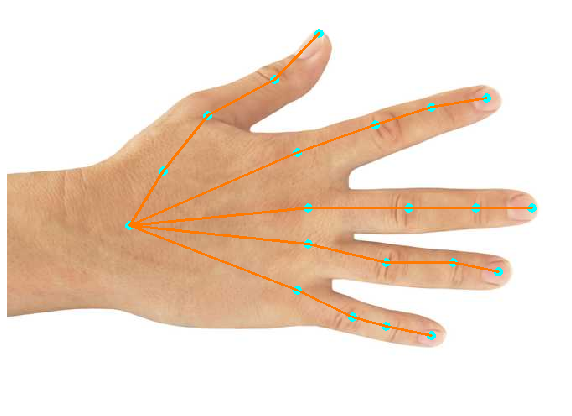

In [43]:
image = cv2.imread("Media/M4/hand16.jpg")
handpose(image)

####  Capturing hand Image from Camera

In [ ]:
handpose(usercam=True)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [ ]:
init_handpose()

In [ ]:
%%time
image= handpose(image = image, returndata=True)

**Intel GPU**

In [ ]:
init_handpose(usegpu = 'opencl')

In [ ]:
%%time
image= handpose(image = image, returndata=True)

**NVIDIA GPU**

In [ ]:
init_handpose(usegpu = 'cuda')

In [ ]:
%%time
image= handpose(image = image, returndata=True)